# Prepare hospital data for Helsinki Region (fake/simulated)

In [86]:
import geopandas as gpd
from pyrosm import OSM, get_data
import pandas as pd
import geoplot as gplt
import matplotlib.pyplot as plt
import contextily as cx

# Read curated list of Health care services for Helsinki Region
data = gpd.read_file("data/Helsinki_Region_Healthcare_All_attributes.geojson")

data.explore()

#### Alternative approach

In [1]:
# ALTERNATIVELY READ ALL FROM WFS
# -------------------------------

# Comment out following if you want to download and filter data yourself
"""
url = "https://kartta.hel.fi/ws/geoserver/avoindata/wfs?request=GetFeature&typename=avoindata:Toimipisterekisteri_palvelut&outputformat=JSON"
data = gpd.read_file(url)

# Select health facilities (that provide doctor's appointments)
health_facilities = ['terveysasemat', 'kaupungin tai kunnan sairaalat', 'yliopistolliset sairaalat', 'päiväsairaalat']
data = data.loc[data["service_fi"].isin(health_facilities)]

# Read boundaries
boundaries = osm.get_boundaries()
boundaries.plot(facecolor="none", edgecolor="blue", lw=1)

# Select data which is within the boundaries
data = data.to_crs(epsg=4326)
data = gpd.sjoin(data, boundaries[["geometry"]])

data = data[['id', 'name_en',
        'address_zip', 'address_city_en', 
        'created_time', 'modified_time',
       'service_ids', 'service_en',
       'datanomistaja', 'geometry']]

data = data.reset_index()

# Harmonize the name for Espoo
data["address_city_en"] = data["address_city_en"].replace(to_replace={"Espoon kaupunki": "Espoo"})
data["address_city_en"].unique()

# Drop duplicates
data = data.drop_duplicates(subset=["name_en"])

# Rename day hospitals as city or municipal hospitals
data["service_en"] = data["service_en"].replace(to_replace={"day hospitals": "city or municipal hospitals"}).copy()

# Drop duplicate geometries - i.e. if there are multiple 
data["wkt"] = data["geometry"].apply(lambda geom: geom.wkt).copy()
data = data.drop_duplicates(subset=["service_en", "wkt"]).copy()
"""

## Assign health related employees for each zipcode

Let's make the number of doctors more realistic by weighting the value based on number of workers working in health sector at a a given zipcode

In [87]:
# Figure out the available layers
from owslib.wfs import WebFeatureService
wfs = WebFeatureService("http://geo.stat.fi/geoserver/postialue/wfs")
list(wfs.contents.keys())

['postialue:pno',
 'postialue:pno_meri',
 'postialue:pno_meri_2015',
 'postialue:pno_meri_2016',
 'postialue:pno_meri_2017',
 'postialue:pno_meri_2018',
 'postialue:pno_meri_2019',
 'postialue:pno_meri_2020',
 'postialue:pno_meri_2021',
 'postialue:pno_meri_2022',
 'postialue:pno_2015',
 'postialue:pno_2016',
 'postialue:pno_2017',
 'postialue:pno_2018',
 'postialue:pno_2019',
 'postialue:pno_2020',
 'postialue:pno_2021',
 'postialue:pno_2022',
 'postialue:pno_tilasto',
 'postialue:pno_tilasto_2015',
 'postialue:pno_tilasto_2016',
 'postialue:pno_tilasto_2017',
 'postialue:pno_tilasto_2018',
 'postialue:pno_tilasto_2019',
 'postialue:pno_tilasto_2020',
 'postialue:pno_tilasto_2021',
 'postialue:pno_tilasto_2022']

In [88]:
# Fetch statistical grid data from PAAVO
url = 'http://geo.stat.fi/geoserver/postialue/wfs?request=GetFeature&typename=postialue:pno_tilasto_2020&outputformat=JSON'
pop_zip = gpd.read_file(url)

In [89]:
# Merge information about population ('tp_q_terv')
data = data.merge(pop_zip[["tp_q_terv", "postinumeroalue"]], left_on="address_zip", right_on="postinumeroalue")
data = data.drop(["postinumeroalue"], axis=1)

In [107]:
data.head(2)

,id,org_id,dept_id,provider_type,data_source_url,name_fi,name_sv,name_en,manual_coordinates,street_address_fi,...,service_sv,service_en,datanomistaja,paivitetty_tietopalveluun,geometry,tp_q_terv,facilities_per_zipcode,health_station,city_hospital,uni_hospital
0,4029,83e74666-0836-4c1d-948a-4b34a8b90301,fff7cfd5-9161-4dad-aa0c-0706a8a63b26,SELF_PRODUCED,www.hel.fi,Koillisen terveysasema/Malmi,Malms hälsostation,Malmi Health Station,No,Talvelantie 4,...,"läkarmottagning,hälsovårdarmottagning,hälsosta...","doctor's appointments,nurse's appointments,hea...",Palvelukartta,2023-01-20,POINT (24.99880 60.25381),2233,3,1,0,0
1,26107,83e74666-0836-4c1d-948a-4b34a8b90301,fff7cfd5-9161-4dad-aa0c-0706a8a63b26,SELF_PRODUCED,www.hel.fi,Malmin sairaala,Malms sjukhus,Malmi Hospital,No,Talvelantie 6,...,"hälsocentraljour och jourpoliklinik för vuxna,...",health centre on-call service and emergency ou...,Palvelukartta,2023-01-20,POINT (24.99880 60.25381),2233,3,0,1,0


In [91]:
# There are cases having multiple facilities under same postal code area
# Need to reflect that in the calculations
value_cnts = data["address_zip"].value_counts()

# Calculate how many facilities there are per zipcode
data["facilities_per_zipcode"] = data["address_zip"].apply(lambda zipcode: value_cnts.to_dict()[zipcode])

In [92]:
# Tag the type of healthcare facility (Health Station, Muni Hospital or City Hospital
data["health_station"] = 0
data["city_hospital"] = 0
data["uni_hospital"] = 0

for idx, row in data.iterrows():
    if "terveysasema" in row["name_fi"].lower():
        data.loc[idx, "health_station"] = 1
    elif "university" in row["service_en"].lower():
        data.loc[idx, "uni_hospital"] = 1
    else:
        data.loc[idx, "city_hospital"] = 1

In [94]:
data.head(2)

,id,org_id,dept_id,provider_type,data_source_url,name_fi,name_sv,name_en,manual_coordinates,street_address_fi,...,service_sv,service_en,datanomistaja,paivitetty_tietopalveluun,geometry,tp_q_terv,facilities_per_zipcode,health_station,city_hospital,uni_hospital
0,4029,83e74666-0836-4c1d-948a-4b34a8b90301,fff7cfd5-9161-4dad-aa0c-0706a8a63b26,SELF_PRODUCED,www.hel.fi,Koillisen terveysasema/Malmi,Malms hälsostation,Malmi Health Station,No,Talvelantie 4,...,"läkarmottagning,hälsovårdarmottagning,hälsosta...","doctor's appointments,nurse's appointments,hea...",Palvelukartta,2023-01-20,POINT (24.99880 60.25381),2233,3,1,0,0
1,26107,83e74666-0836-4c1d-948a-4b34a8b90301,fff7cfd5-9161-4dad-aa0c-0706a8a63b26,SELF_PRODUCED,www.hel.fi,Malmin sairaala,Malms sjukhus,Malmi Hospital,No,Talvelantie 6,...,"hälsocentraljour och jourpoliklinik för vuxna,...",health centre on-call service and emergency ou...,Palvelukartta,2023-01-20,POINT (24.99880 60.25381),2233,3,0,1,0


In [95]:
hki = data.loc[data["address_city_en"]=="Helsinki"].copy()
espoo = data.loc[data["address_city_en"]=="Espoo"].copy()
vantaa = data.loc[data["address_city_en"]=="Vantaa"].copy()
kauniainen = data.loc[data["address_city_en"]=="Kauniainen"].copy()

In [96]:
# Create number of doctors
# ------------------------
# Sources: https://www.laakariliitto.fi/laakariliitto/tutkimus/laakarityovoima/
# https://www.laakariliitto.fi/site/assets/files/5223/2019_terveyskeskustilanne_yksittaiset_terveyskeskukset_2019.pdf
# https://www.hel.fi/toihinsoteen/fi/laakariksi-helsinkiin/


# Number of doctors on average in Finland is 3.8 per 1000 invididuals
# Helsinki has 658864 inhabitants
# Meaning that the number of doctors in Helsinki is ~2500

hki_doctors = (658863/1000)*3.8
espoo_doctors = (302670/1000)*3.8
vantaa_doctors = (242300/1000)*3.8
kauniainen_doctors = 9

# In hospitals there are on average 50 % of the doctors and 25 % are in health care centers
uni_hospital_share = 0.55
muni_hospital_share = 0.20 # includes other as well
healthcare_center_share = 0.25

In [104]:
hki.head(2)

,id,org_id,dept_id,provider_type,data_source_url,name_fi,name_sv,name_en,manual_coordinates,street_address_fi,...,service_sv,service_en,datanomistaja,paivitetty_tietopalveluun,geometry,tp_q_terv,facilities_per_zipcode,health_station,city_hospital,uni_hospital
0,4029,83e74666-0836-4c1d-948a-4b34a8b90301,fff7cfd5-9161-4dad-aa0c-0706a8a63b26,SELF_PRODUCED,www.hel.fi,Koillisen terveysasema/Malmi,Malms hälsostation,Malmi Health Station,No,Talvelantie 4,...,"läkarmottagning,hälsovårdarmottagning,hälsosta...","doctor's appointments,nurse's appointments,hea...",Palvelukartta,2023-01-20,POINT (24.99880 60.25381),2233,3,1,0,0
1,26107,83e74666-0836-4c1d-948a-4b34a8b90301,fff7cfd5-9161-4dad-aa0c-0706a8a63b26,SELF_PRODUCED,www.hel.fi,Malmin sairaala,Malms sjukhus,Malmi Hospital,No,Talvelantie 6,...,"hälsocentraljour och jourpoliklinik för vuxna,...",health centre on-call service and emergency ou...,Palvelukartta,2023-01-20,POINT (24.99880 60.25381),2233,3,0,1,0


In [98]:
# Number of health stations
hki_healthstat_cnt = hki["health_station"].sum()
vantaa_healthstat_cnt = vantaa["health_station"].sum()
espoo_healthstat_cnt = espoo["health_station"].sum()
kauniainen_healthstat_cnt = kauniainen["health_station"].sum()

# Number of doctors per station
hki_doctors_per_station = (hki_doctors * healthcare_center_share) / hki_healthstat_cnt
vantaa_doctors_per_station = (vantaa_doctors * healthcare_center_share) / vantaa_healthstat_cnt
espoo_doctors_per_station = (espoo_doctors * healthcare_center_share) / espoo_healthstat_cnt

In [99]:
print(f"Helsinki doctors per station (n={hki_healthstat_cnt})", hki_doctors_per_station)
print(f"Vantaa doctors per station (n={vantaa_healthstat_cnt})", vantaa_doctors_per_station)
print(f"Espoo doctors per station (n={espoo_healthstat_cnt})", espoo_doctors_per_station)

Helsinki doctors per station (n=23) 27.21390652173913
Vantaa doctors per station (n=7) 32.88357142857143
Espoo doctors per station (n=11) 26.139681818181817


In [108]:
hki.loc[hki["uni_hospital"]==1]

,id,org_id,dept_id,provider_type,data_source_url,name_fi,name_sv,name_en,manual_coordinates,street_address_fi,...,service_sv,service_en,datanomistaja,paivitetty_tietopalveluun,geometry,tp_q_terv,facilities_per_zipcode,health_station,city_hospital,uni_hospital
2,70440,84075c47-a8e4-4a45-a109-65221f63b3bf,84075c47-a8e4-4a45-a109-65221f63b3bf,SELF_PRODUCED,www.hus.fi,Malmin sairaala,Malms sjukhus,Malmi Hospital,Yes,Talvelantie 6,...,"hälsocentraljour och jourpoliklinik för vuxna,...",health centre on-call service and emergency ou...,Palvelukartta,2023-01-20,POINT (24.99992 60.25432),2233,3,0,0,1
18,16114,84075c47-a8e4-4a45-a109-65221f63b3bf,84075c47-a8e4-4a45-a109-65221f63b3bf,SELF_PRODUCED,www.hus.fi,Töölön sairaala,Tölö sjukhus,Töölö Hospital,Yes,Topeliuksenkatu 5,...,"laboratorier,röntgen,universitetssjukhus","laboratories,x-rays,university hospitals",Palvelukartta,2023-01-20,POINT (24.92082 60.18133),3905,3,0,0,1
19,70461,84075c47-a8e4-4a45-a109-65221f63b3bf,84075c47-a8e4-4a45-a109-65221f63b3bf,SELF_PRODUCED,www.hus.fi,"Tapaturma-asema, Töölön sairaala","Olycksfallsstationen, Tölö sjukhus","Emergency Department, Töölö Hospital",Yes,Topeliuksenkatu 5,...,universitetssjukhus,university hospitals,Palvelukartta,2023-01-20,POINT (24.92082 60.18133),3905,3,0,0,1
26,16109,84075c47-a8e4-4a45-a109-65221f63b3bf,84075c47-a8e4-4a45-a109-65221f63b3bf,SELF_PRODUCED,www.hus.fi,Meilahden tornisairaala,Mejlans tornsjukhus,Meilahti Tower Hospital,Yes,Haartmaninkatu 4,...,"laboratorier,röntgen,universitetssjukhus","laboratories,x-rays,university hospitals",Palvelukartta,2023-01-20,POINT (24.90795 60.19048),8355,4,0,0,1
27,16322,84075c47-a8e4-4a45-a109-65221f63b3bf,84075c47-a8e4-4a45-a109-65221f63b3bf,SELF_PRODUCED,www.hus.fi,Meilahden kolmiosairaala,Mejlans triangelsjukhus,Meilahti Triangle Hospital,Yes,Haartmaninkatu 4,...,"röntgen,universitetssjukhus","x-rays,university hospitals",Palvelukartta,2023-01-20,POINT (24.90795 60.19048),8355,4,0,0,1
28,70428,84075c47-a8e4-4a45-a109-65221f63b3bf,84075c47-a8e4-4a45-a109-65221f63b3bf,SELF_PRODUCED,www.hus.fi,Haartmanin sairaala,Haartmanska sjukhuset,Haartman Hospital,Yes,Haartmaninkatu 4,...,"hälsocentraljour och jourpoliklinik för vuxna,...",health centre on-call service and emergency ou...,Palvelukartta,2023-01-20,POINT (24.90795 60.19048),8355,4,0,0,1
29,70452,84075c47-a8e4-4a45-a109-65221f63b3bf,84075c47-a8e4-4a45-a109-65221f63b3bf,SELF_PRODUCED,www.hus.fi,Puistosairaala,Parksjukhuset,Park Hospital,Yes,Stenbäckinkatu 11,...,"röntgen,universitetssjukhus","x-rays,university hospitals",Palvelukartta,2023-01-20,POINT (24.91004 60.18691),8355,4,0,0,1


In [109]:
# Number of Uni hospitals
hki_unihosp_cnt = hki["uni_hospital"].sum()
vantaa_unihosp_cnt = vantaa["uni_hospital"].sum()
espoo_unihosp_cnt = espoo["uni_hospital"].sum()

# Number of doctors per Uni hospital
hki_doctors_per_unihosp = (hki_doctors * uni_hospital_share) / hki_unihosp_cnt
vantaa_doctors_per_unihosp = (vantaa_doctors * uni_hospital_share) / vantaa_unihosp_cnt
espoo_doctors_per_unihosp = (espoo_doctors * uni_hospital_share) / espoo_unihosp_cnt

In [110]:
print(f"Helsinki doctors per Uni hospital (n={hki_unihosp_cnt})", hki_doctors_per_unihosp)
print(f"Vantaa doctors per Uni hospital (n={vantaa_unihosp_cnt})", vantaa_doctors_per_unihosp)
print(f"Espoo doctors per Uni hospital (n={espoo_unihosp_cnt})", espoo_doctors_per_unihosp)

Helsinki doctors per Uni hospital (n=7) 196.71766714285715
Vantaa doctors per Uni hospital (n=1) 506.40700000000004
Espoo doctors per Uni hospital (n=1) 632.5803000000001


In [111]:
# Number of Muni hospitals
hki_munihosp_cnt = hki["city_hospital"].sum()
vantaa_munihosp_cnt = vantaa["city_hospital"].sum()
espoo_munihosp_cnt = espoo["city_hospital"].sum()

# Number of doctors per Muni hospital
hki_doctors_per_munihosp = (hki_doctors * muni_hospital_share) / hki_munihosp_cnt
vantaa_doctors_per_munihosp = (vantaa_doctors * muni_hospital_share) / vantaa_munihosp_cnt
espoo_doctors_per_munihosp = (espoo_doctors * muni_hospital_share) / espoo_munihosp_cnt

In [112]:
print(f"Helsinki doctors per Municipal hospital (n={hki_munihosp_cnt})", hki_doctors_per_munihosp)
print(f"Vantaa doctors per Municipal hospital (n={vantaa_munihosp_cnt})", vantaa_doctors_per_munihosp)
print(f"Espoo doctors per Municipal hospital (n={espoo_munihosp_cnt})", espoo_doctors_per_munihosp)

Helsinki doctors per Municipal hospital (n=3) 166.91196
Vantaa doctors per Municipal hospital (n=2) 92.07400000000001
Espoo doctors per Municipal hospital (n=1) 230.0292


## Calculate physician weights

Physician weights are based on the postalcode where the facility is located and the number of employees working on health sector there (gives some kind of estimate about the demand for given facility which is assumed to reflect also the number of doctors in given facility). 

In [113]:
# Average number of employees working in areas where facilities are located
hki_empl_avg = hki.drop_duplicates(subset=["address_zip"])["tp_q_terv"].mean()
vantaa_empl_avg = vantaa.drop_duplicates(subset=["address_zip"])["tp_q_terv"].mean()
espoo_empl_avg = espoo.drop_duplicates(subset=["address_zip"])["tp_q_terv"].mean()

In [114]:
print("Helsinki avg number of healthcare related employees in neighborhoods with health facility:", hki_empl_avg)
print("Vantaa avg number of healthcare related employees in neighborhoods with health facility:", vantaa_empl_avg)
print("Espoo avg number of healthcare related employees in neighborhoods with health facility:", espoo_empl_avg)

Helsinki avg number of healthcare related employees in neighborhoods with health facility: 1222.8333333333333
Vantaa avg number of healthcare related employees in neighborhoods with health facility: 893.2222222222222
Espoo avg number of healthcare related employees in neighborhoods with health facility: 761.3


In [115]:
# Assign weights
hki["weight"] = (hki["tp_q_terv"] / hki_empl_avg) / hki["facilities_per_zipcode"]
vantaa["weight"] = (vantaa["tp_q_terv"] / vantaa_empl_avg) / vantaa["facilities_per_zipcode"]
espoo["weight"] = (espoo["tp_q_terv"] / espoo_empl_avg) / espoo["facilities_per_zipcode"]

## Assign number of doctors for each health facility

In [116]:
# Helsinki
# --------
hki["physician_cnt"] = None

# Stations
mask = hki["health_station"]==1
hki.loc[mask, "physician_cnt"] = (hki_doctors_per_station * hki.loc[mask, "weight"]).round(0).astype(int)

# Uni hospitals
mask = hki["uni_hospital"]==1
hki.loc[mask, "physician_cnt"] = (hki_doctors_per_unihosp * hki.loc[mask, "weight"]).round(0).astype(int)

# Municipality hospitals
mask = hki["city_hospital"]==1
hki.loc[mask, "physician_cnt"] = (hki_doctors_per_munihosp * hki.loc[mask, "weight"]).round(0).astype(int)


# Vantaa
# --------

vantaa["physician_cnt"] = None

# Stations
mask = vantaa["health_station"]==1
vantaa.loc[mask, "physician_cnt"] = (vantaa_doctors_per_station * vantaa.loc[mask, "weight"]).round(0).astype(int)

# Uni hospitals
mask = vantaa["uni_hospital"]==1
vantaa.loc[mask, "physician_cnt"] = (vantaa_doctors_per_unihosp * vantaa.loc[mask, "weight"]).round(0).astype(int)

# Municipality hospitals
mask = vantaa["city_hospital"]==1
vantaa.loc[mask, "physician_cnt"] = (vantaa_doctors_per_munihosp * vantaa.loc[mask, "weight"]).round(0).astype(int)

# Espoo
# --------
espoo["physician_cnt"] = None

# Stations
mask = espoo["health_station"]==1
espoo.loc[mask, "physician_cnt"] = (espoo_doctors_per_station * espoo.loc[mask, "weight"]).round(0).astype(int)

# Uni hospitals
mask = espoo["uni_hospital"]==1
espoo.loc[mask, "physician_cnt"] = (espoo_doctors_per_unihosp * espoo.loc[mask, "weight"]).round(0).astype(int)

# Municipality hospitals
mask = espoo["city_hospital"]==1
espoo.loc[mask, "physician_cnt"] = (espoo_doctors_per_munihosp * espoo.loc[mask, "weight"]).round(0).astype(int)

# Kauniainen
# ----------
# In Kauniainen, there is 1 health station with 9 doctors
kauniainen["physician_cnt"] = 9


In [117]:
# Check doctor counts
print("Helsinki physician count:", hki["physician_cnt"].sum())
print("Vantaa physician count:", vantaa["physician_cnt"].sum())
print("Espoo physician count:", espoo["physician_cnt"].sum())

Helsinki physician count: 2796
Vantaa physician count: 821
Espoo physician count: 1550


In [140]:
# Merge the data 
combined = pd.concat([hki, espoo, vantaa, kauniainen], ignore_index=True)

# Assign names for different type of health facilities
combined["facility_type"] = None
combined.loc[combined["health_station"]==1 , "facility_type"] = "health-station"
combined.loc[combined["uni_hospital"]==1 , "facility_type"] = "university-hospital"
combined.loc[combined["city_hospital"]==1 , "facility_type"] = "city-hospital"

# Select only relevant columns
combined = combined[['name_fi', 'name_en', "facility_type", 'address_zip', 'address_city_en',  'geometry', 'physician_cnt']]

In [141]:
combined.head(3)

,name_fi,name_en,facility_type,address_zip,address_city_en,geometry,physician_cnt
0,Koillisen terveysasema/Malmi,Malmi Health Station,health-station,00700,Helsinki,POINT (24.99880 60.25381),17
1,Malmin sairaala,Malmi Hospital,city-hospital,00700,Helsinki,POINT (24.99880 60.25381),102
2,Malmin sairaala,Malmi Hospital,university-hospital,00700,Helsinki,POINT (24.99992 60.25432),120


## Sum physician counts together if they are the same type and under the same Zip-code

In [248]:
# Drop exact duplicates
combined = combined.drop_duplicates(subset=["name_fi", "facility_type", "physician_cnt"])

final = []

# Merge the physician counts for facilities that are located on same building together
combined["wkt"] = combined.geometry.to_wkt()

# Group and parse info
grouped = combined.groupby(["wkt"])
for postcode, group in grouped:
    
    cnt = group["physician_cnt"].sum()
    name_fi = "; ".join(group["name_fi"].to_list())
    if group["name_en"].values[0] == None:
        name_en = None
    else:
        name_en = "; ".join(group["name_en"].to_list())
    facility_type = "; ".join(group["facility_type"].unique())
    address_zip = group["address_zip"].values[0]
    city = group["address_city_en"].values[0]
    geometry = group["geometry"].values[0]
    row = {"name_fi": name_fi, 
           "name_en": name_en,
           "facility_type": facility_type, 
           "postal_code": address_zip, 
           "city": city, 
           "physician_cnt": cnt, 
           "geometry": geometry}
    final.append(row)
    
final_gdf = gpd.GeoDataFrame(final, geometry="geometry", crs=combined.crs) 

/tmp/ipykernel_654168/3959733311.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for postcode, group in grouped:


## Drop hospitals which does not provide "normal" healthcare services 

In [249]:
# Puistosairaala offers plastic surgery etc. Töölö hospital will be closed very soon and those services are moved to Siltasairaala in Meilahti 
# Drop the first one and combine the latter with Meilahti
toolo_cnt = final_gdf.loc[final_gdf["name_fi"]=="Töölön sairaala; Tapaturma-asema, Töölön sairaala", "physician_cnt"].values[0]
mask = final_gdf["name_fi"]=='Meilahden tornisairaala; Meilahden kolmiosairaala; Haartmanin sairaala'
meilahti_cnt = final_gdf.loc[mask, "physician_cnt"].values[0]
new_cnt = toolo_cnt + meilahti_cnt

# Apply new count
final_gdf.loc[mask, "physician_cnt"] = new_cnt

# Add 'Siltasairaala' to list
final_gdf.loc[mask, "name_fi"] = 'Meilahden tornisairaala; Meilahden kolmiosairaala; Haartmanin sairaala; Siltasairaala'
final_gdf.loc[mask, "name_en"] = 'Meilahti Tower Hospital; Meilahti Triangle Hospital; Haartman Hospital; Meilahti Bridge Hospital'

final_gdf = final_gdf.loc[~final_gdf["name_fi"].isin(["Puistosairaala", "Töölön sairaala; Tapaturma-asema, Töölön sairaala"])]

In [251]:
import numpy as np
final_gdf.explore(color="Blue",
                  style_kwds={"style_function": lambda x: {
                        "radius": np.sqrt(x["properties"]["physician_cnt"])*0.7,
                        "stroke": True,  
                        "color": "blue",
                        "weight": 1,    
                  }
                }
                  
                 )

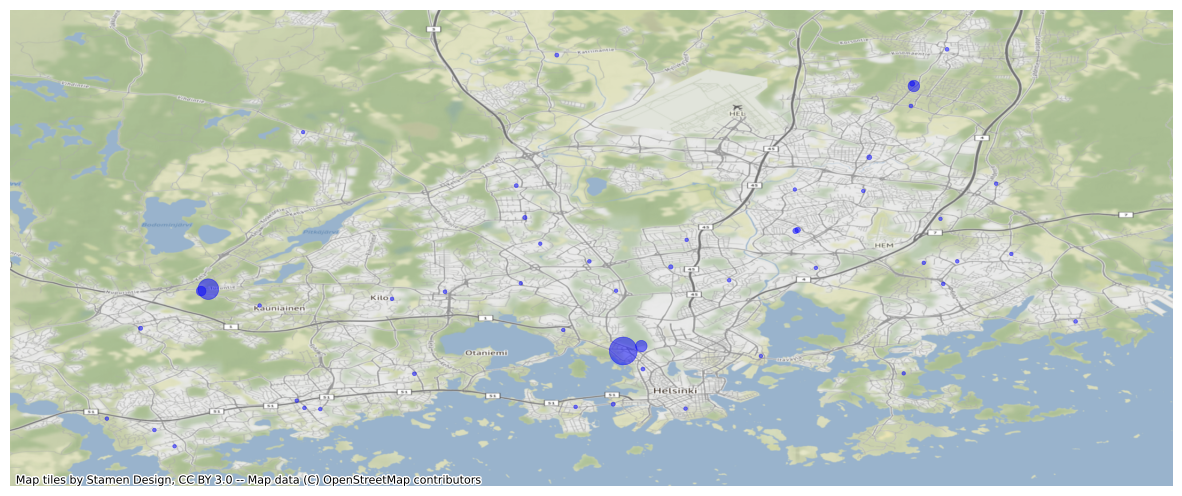

In [253]:
fig, ax = plt.subplots(figsize=(15,15))

gplt.pointplot(
                final_gdf,
                ax=ax, limits=(2.5, 20),
                scale="physician_cnt",
                lw=0.5,
                color="blue",
                alpha=0.5
)
cx.add_basemap(ax, crs=final_gdf.crs.to_string())

In [252]:
# Save to disk
final_gdf.to_file("data/hospital_data.geojson", driver="GeoJSON")